<a href="https://colab.research.google.com/github/AndreBrusco/airline-network-shortest-paths/blob/main/notebooks/Codeshare_Gol_Azul_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Codeshare Gol + Azul com Algoritmo de Johnson

## Objetivo
Implementar um grafo combinado da malha aérea da Gol e Azul simulando codeshare total, e usar o algoritmo de Johnson para identificar oportunidades reais de codeshare onde o menor caminho envolve ambas as companhias.

## Metodologia
1. **Coleta de dados**: Malhas aéreas da Gol e Azul com coordenadas geográficas
2. **Construção do grafo**: Rede combinada com 153 aeroportos e 450 rotas
3. **Algoritmo de Johnson**: Cálculo de caminhos mínimos entre todos os pares
4. **Análise de codeshare**: Identificação de rotas que utilizam ambas as companhias

## Resultados Principais
- **400 oportunidades de codeshare** identificadas
- **90.5% rotas internacionais**, demonstrando complementaridade das malhas
- **GRU como principal hub** de conexão (206 conexões)
- **Rota mais eficiente**: PDP ↔ AEP (1.499 km, 1 escala)

## 1. Importação de Bibliotecas e Configuração

In [1]:
# 1. Clonar o repositório
!git clone https://github.com/rglopesdf/airline-network-shortest-paths.git

# 2. Navegar para o diretório
import os
os.chdir('airline-network-shortest-paths' )

# 3. Instalar dependências
!pip install -r requirements.txt

# 4. Verificar estrutura do projeto
!ls -la

# 5. Listar notebooks disponíveis
!ls notebooks/

print("✅ Projeto clonado e configurado com sucesso!")
print("📁 Diretório atual:", os.getcwd())


Cloning into 'airline-network-shortest-paths'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 55 (delta 8), reused 45 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 7.40 MiB | 11.04 MiB/s, done.
Resolving deltas: 100% (8/8), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00
  Attempting u

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import json
import warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso


## 2. Funções Auxiliares

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos na Terra usando a fórmula de Haversine
    Retorna a distância em quilômetros
    """
    # Converter graus para radianos
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Fórmula de Haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Raio da Terra em quilômetros
    return c * r

def algoritmo_johnson_combinado(G):
    """
    Implementação do algoritmo de Johnson adaptada para a malha aérea combinada
    Baseada no código original do usuário
    """
    # Criar cópia do grafo e adicionar vértice auxiliar
    G_aux = G.copy()
    G_aux.add_node('q')
    for node in G.nodes():
        G_aux.add_edge('q', node, weight=0)

    try:
        # Executar Bellman-Ford a partir do vértice auxiliar
        h = nx.single_source_bellman_ford_path_length(G_aux, 'q', weight='weight')
    except nx.NetworkXUnbounded:
        raise Exception("O grafo possui ciclo negativo!")

    # Reponderar as arestas
    G_reponderado = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        w = data['weight']
        w_prime = w + h[u] - h[v]
        G_reponderado.add_edge(u, v, weight=w_prime)

    # Executar Dijkstra a partir de cada vértice
    dist = dict()
    paths = dict()
    for node in G_reponderado.nodes():
        d, p = nx.single_source_dijkstra(G_reponderado, node, weight='weight')
        dist[node] = d
        paths[node] = p

    # Corrigir as distâncias para o grafo original
    for u in dist:
        for v in dist[u]:
            dist[u][v] = dist[u][v] + h[v] - h[u]

    return dist, paths

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 3. Carregamento e Análise dos Dados

In [4]:
# Carregar dados das companhias
print("Carregando dados das malhas aéreas...")

# Dados da Gol
gol_airports = pd.read_csv('data/processed/gol_airports_coordinates.csv')
gol_codes = set(gol_airports['code'])

# Dados da Azul
azul_airports = pd.read_csv('data/processed/azul_airports_coordinates.csv')
azul_codes = set(azul_airports['code'])

# Dados combinados
combined_airports = pd.read_csv('data/processed/combined_airports_coordinates.csv')
both_codes = gol_codes.intersection(azul_codes)

print(f"Gol: {len(gol_codes)} aeroportos")
print(f"Azul: {len(azul_codes)} aeroportos")
print(f"Em comum: {len(both_codes)} aeroportos")
print(f"Total único: {len(combined_airports)} aeroportos")

# Estatísticas básicas
comparison_stats = pd.DataFrame({
    'Métrica': ['Aeroportos Gol', 'Aeroportos Azul', 'Em Comum', 'Total Único'],
    'Valor': [len(gol_codes), len(azul_codes), len(both_codes), len(combined_airports)]
})

display(comparison_stats)

Carregando dados das malhas aéreas...
Gol: 76 aeroportos
Azul: 140 aeroportos
Em comum: 63 aeroportos
Total único: 153 aeroportos


Métrica  Valor
0   Aeroportos Gol     76
1  Aeroportos Azul    140
2         Em Comum     63
3      Total Único    153

🗺️ Mapa da Rede Combinada:


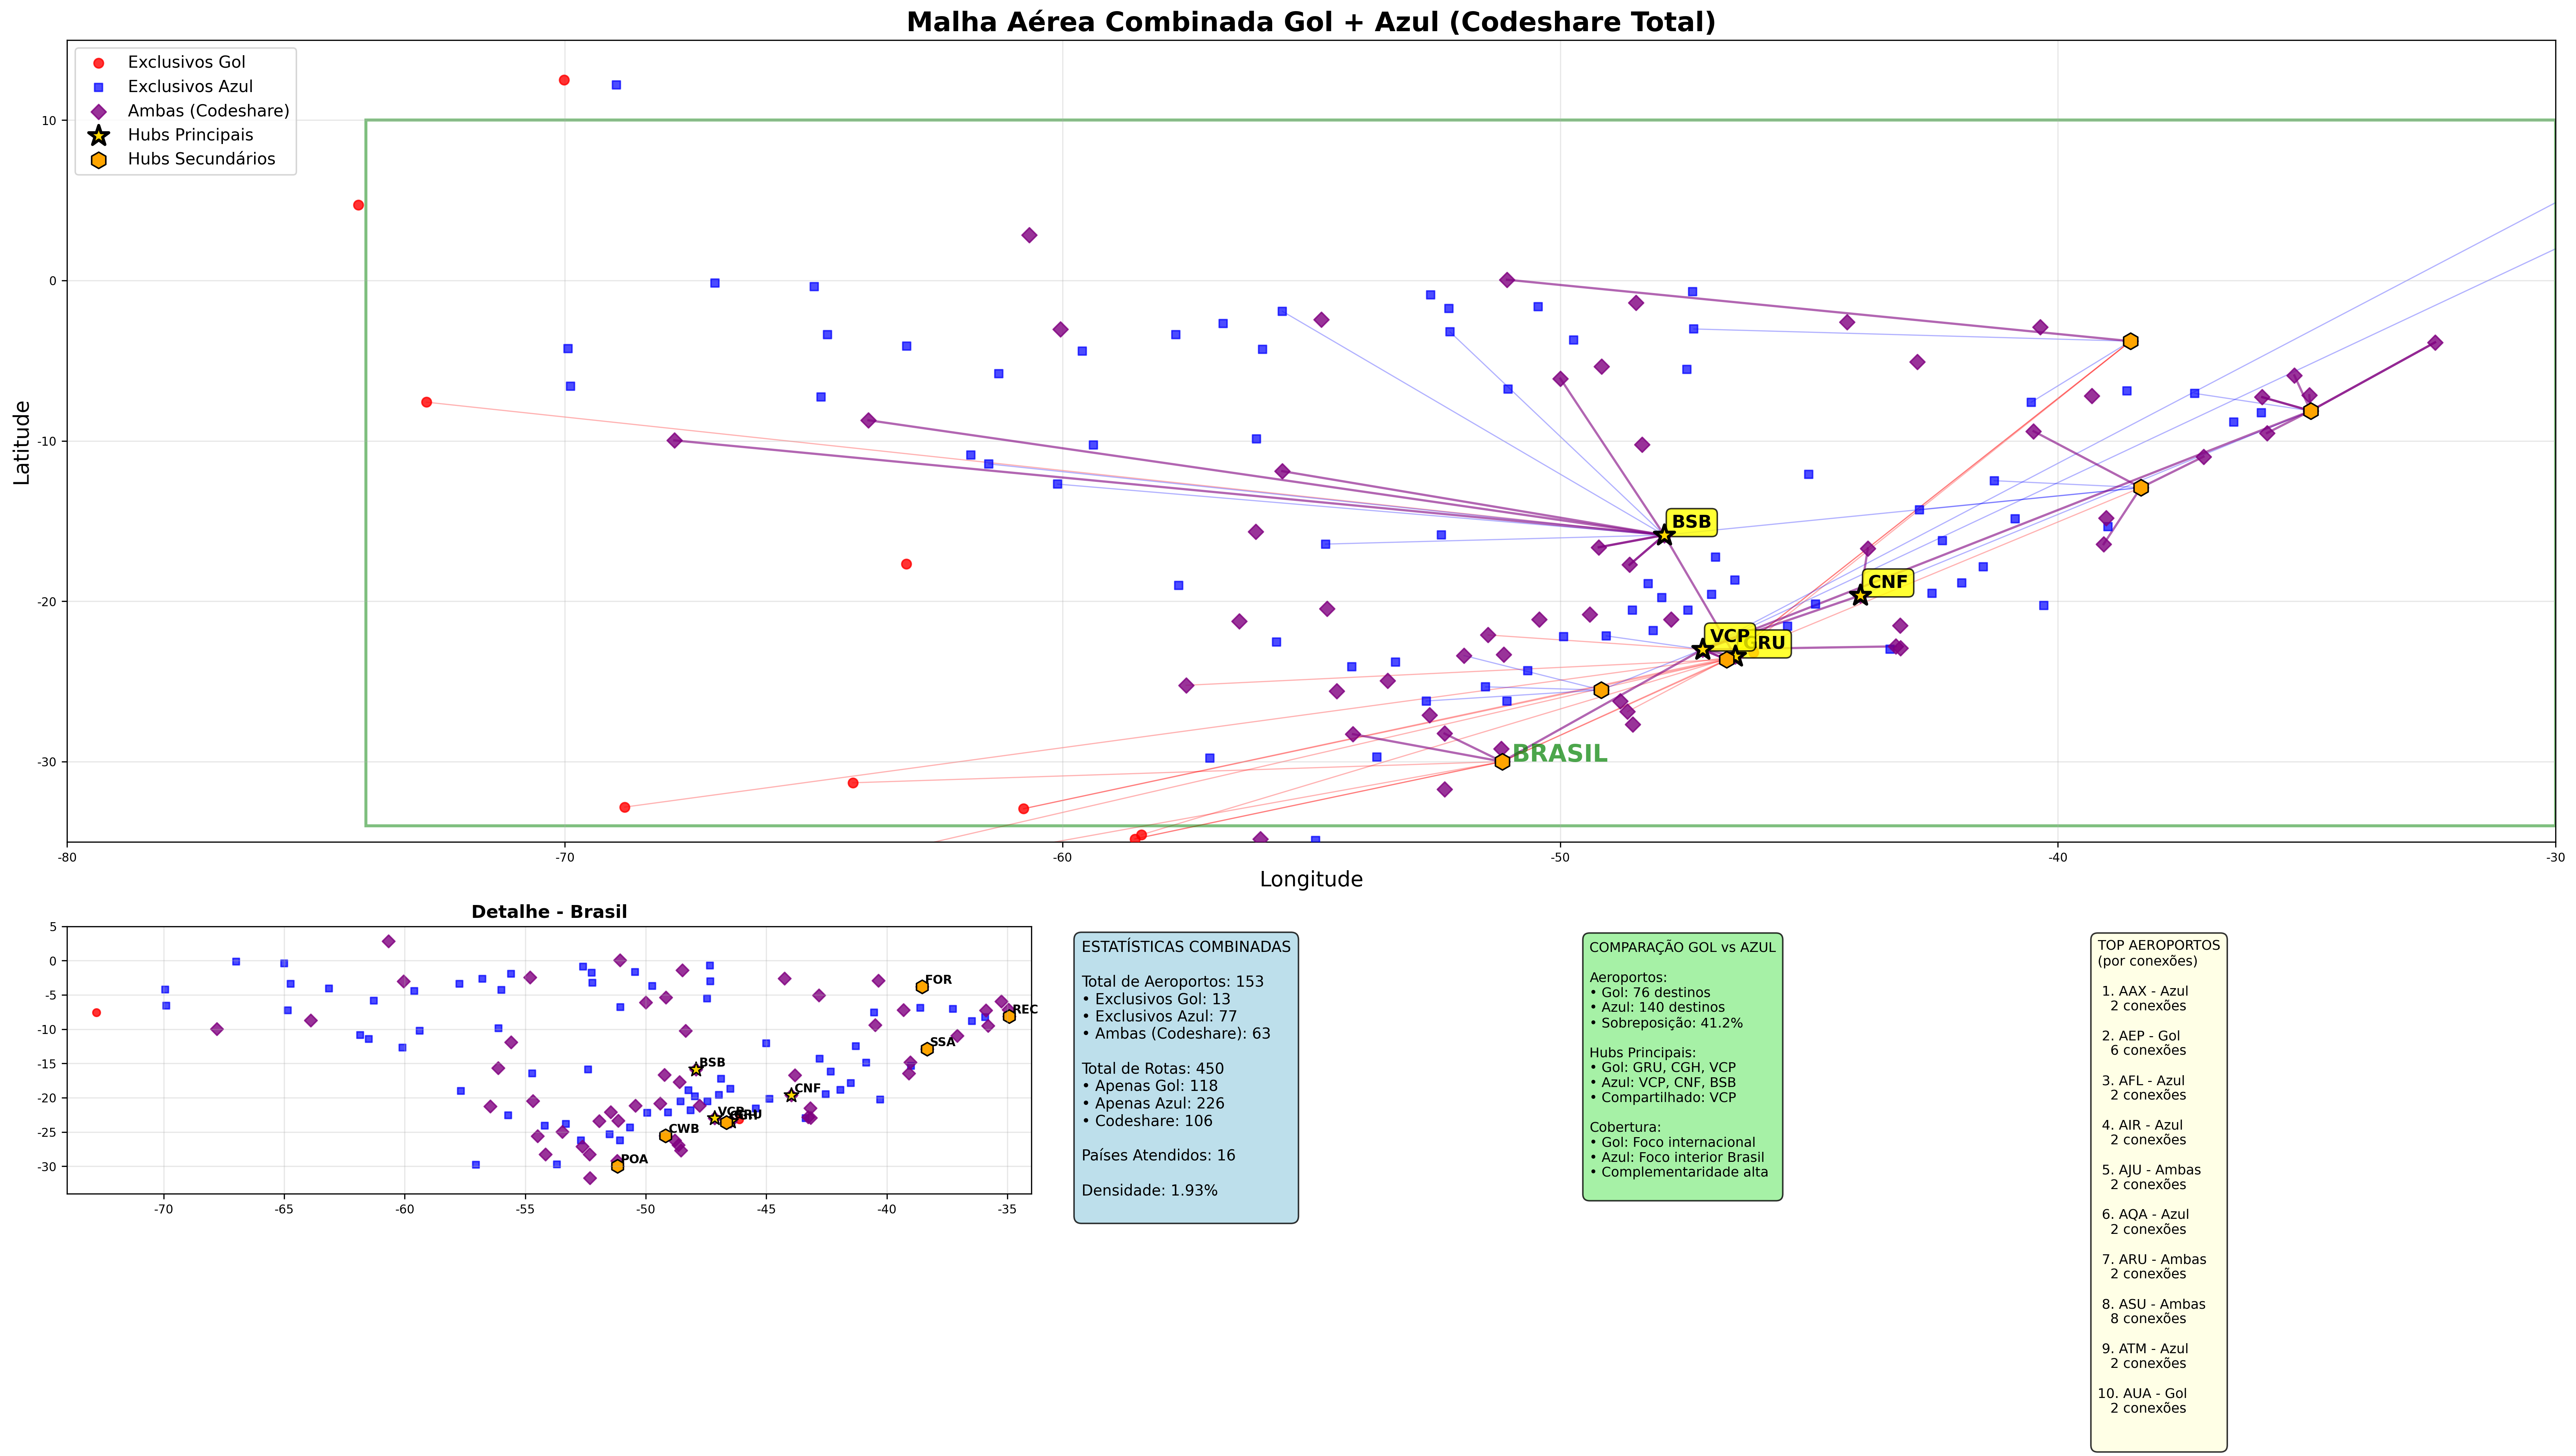


📊 Análise de Oportunidades:


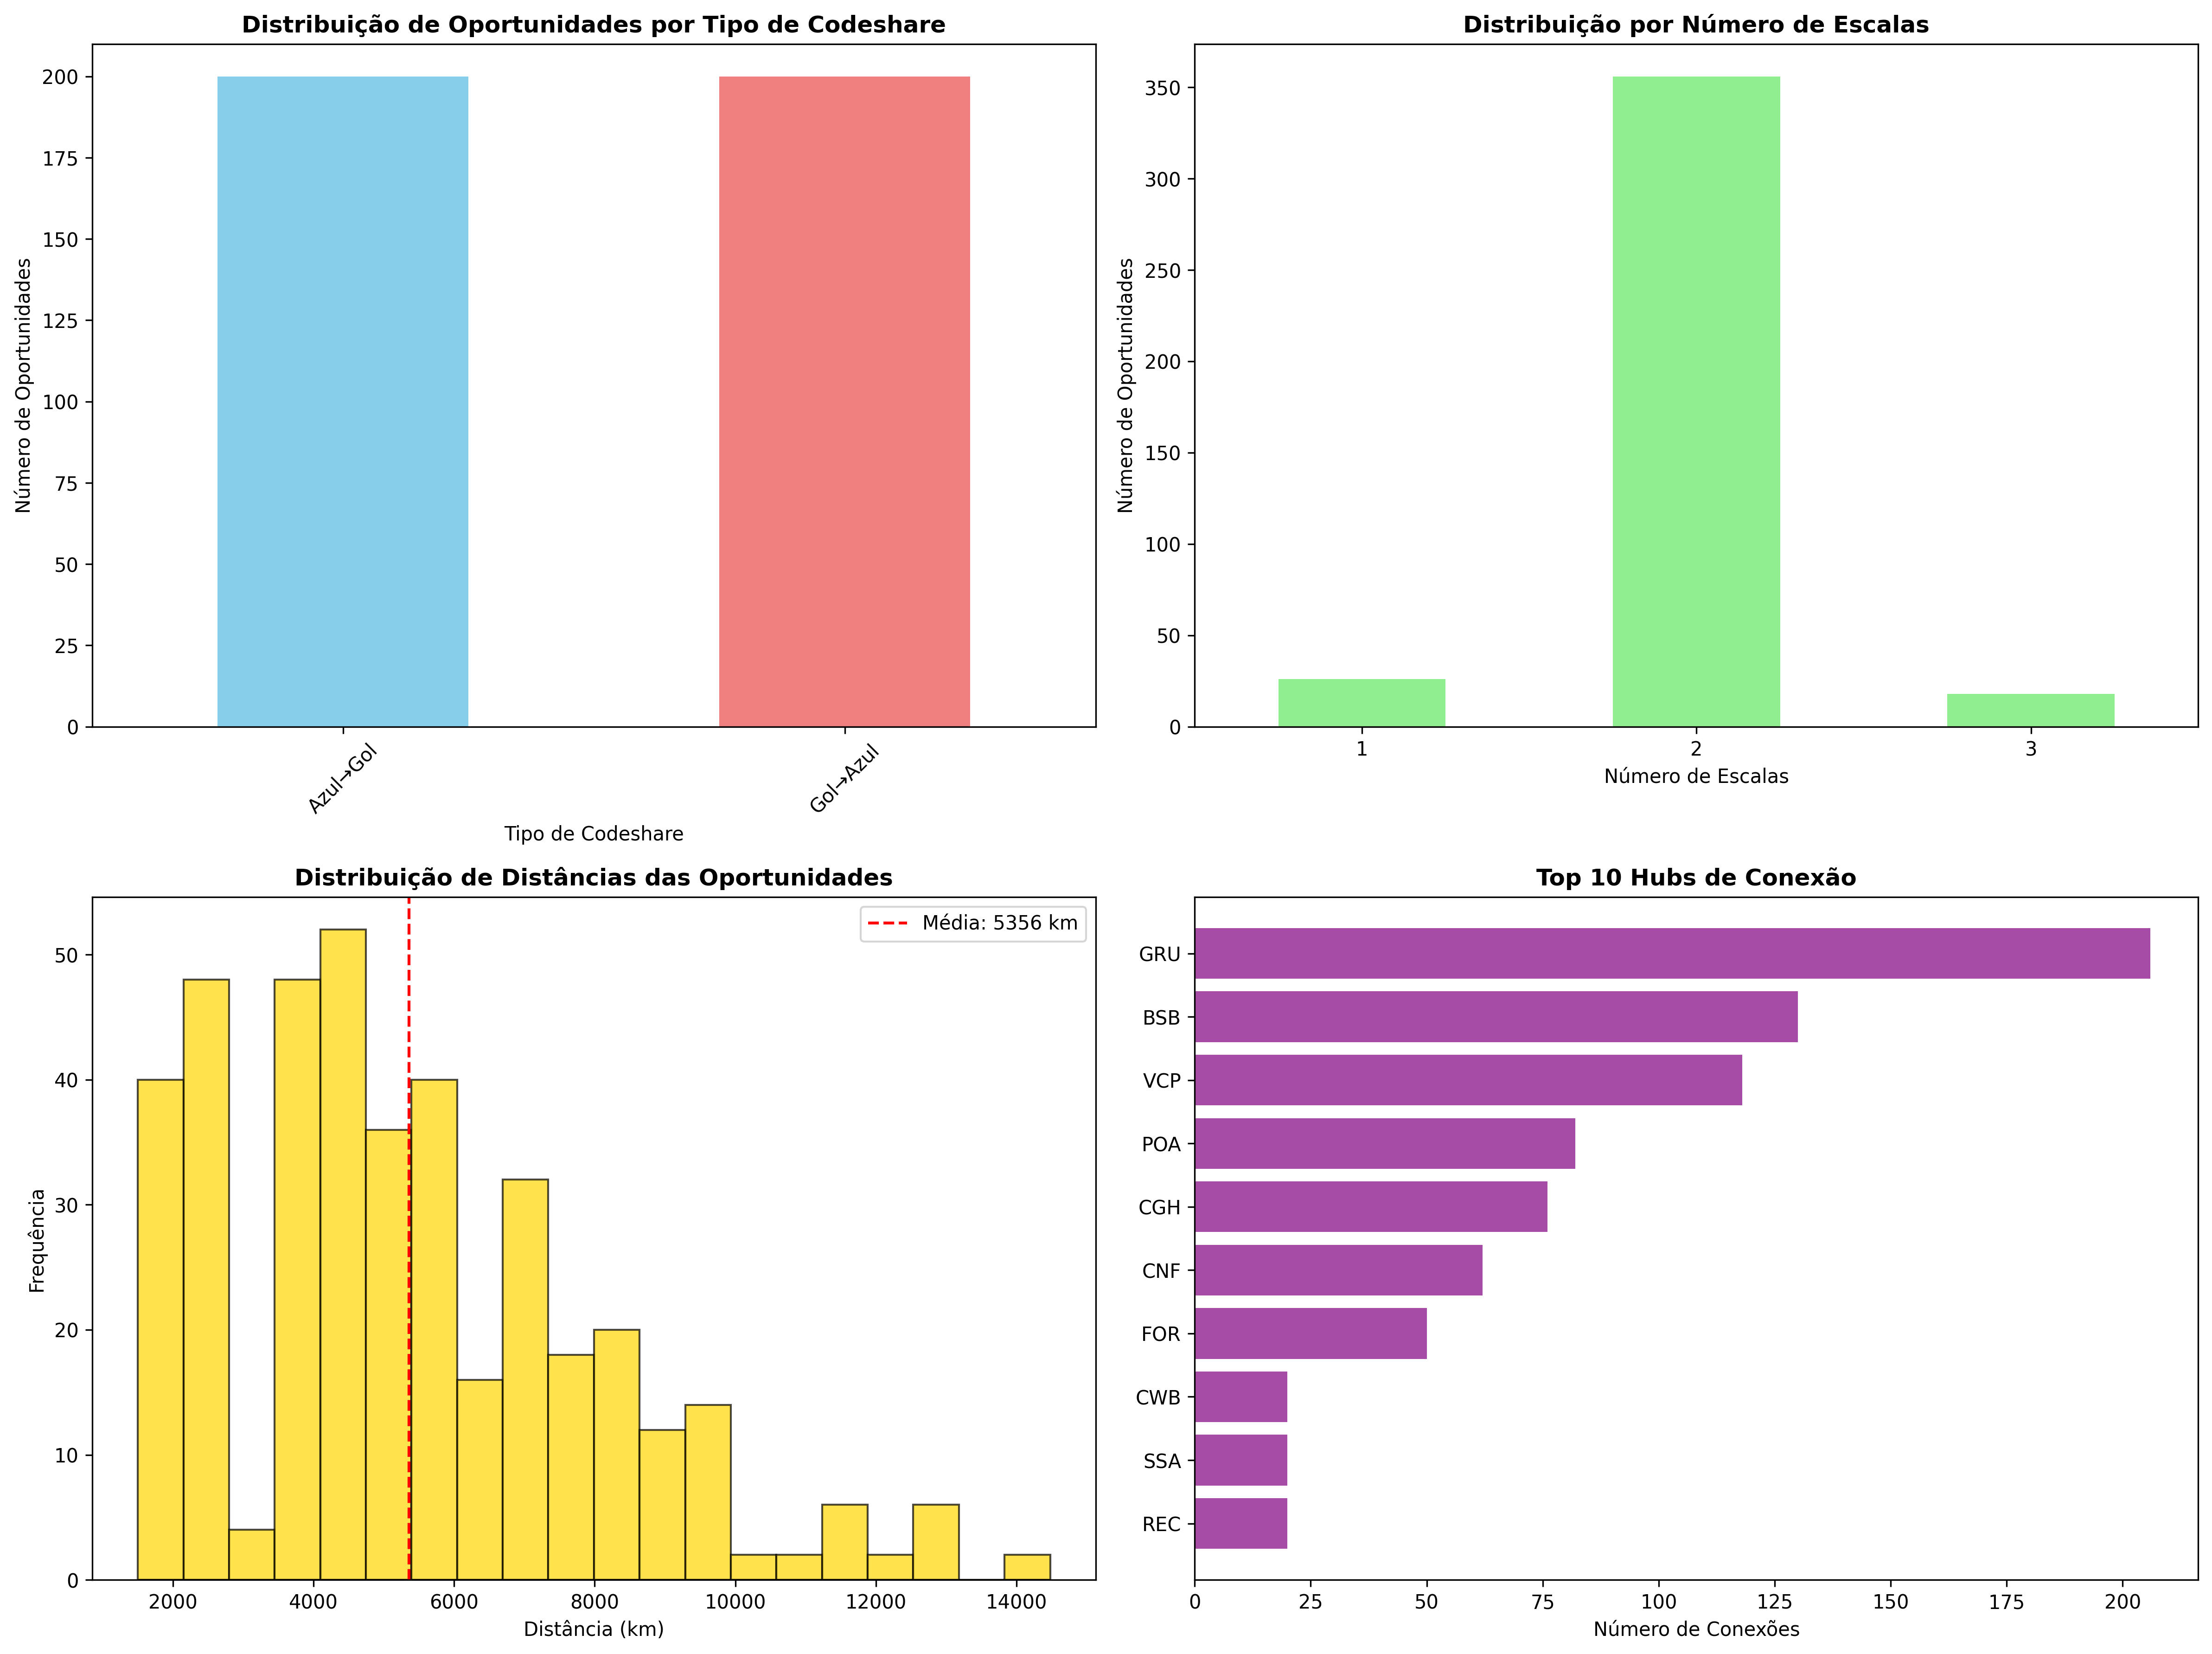

In [5]:
# Mostrar visualizações
from IPython.display import Image, display

print("🗺️ Mapa da Rede Combinada:")
display(Image('images/combined_network_map.png'))

print("\n📊 Análise de Oportunidades:")
display(Image('images/codeshare_opportunities_analysis.png'))


## 4. Construção do Grafo Combinado

In [6]:
# Carregar grafo combinado pré-construído
print("Carregando grafo combinado...")
G = nx.read_graphml('data/processed/combined_network.graphml')

print(f"Grafo carregado: {len(G.nodes())} nós, {len(G.edges())} arestas")
print(f"Densidade: {nx.density(G):.4f}")
print(f"Conectividade: {'Sim' if nx.is_weakly_connected(G) else 'Não'}")

# Analisar tipos de arestas
edge_types = {'Gol': 0, 'Azul': 0, 'Codeshare': 0}
for u, v, data in G.edges(data=True):
    airlines_str = data.get('airlines_str', '')
    if ',' in airlines_str:
        edge_types['Codeshare'] += 1
    elif 'Gol' in airlines_str:
        edge_types['Gol'] += 1
    else:
        edge_types['Azul'] += 1

print(f"\nTipos de rotas:")
for tipo, count in edge_types.items():
    print(f"  {tipo}: {count} rotas")

# Visualizar estatísticas do grafo
graph_stats = pd.DataFrame({
    'Métrica': ['Aeroportos', 'Rotas', 'Densidade', 'Rotas Gol', 'Rotas Azul', 'Rotas Codeshare'],
    'Valor': [len(G.nodes()), len(G.edges()), f"{nx.density(G):.4f}",
              edge_types['Gol'], edge_types['Azul'], edge_types['Codeshare']]
})

display(graph_stats)

Carregando grafo combinado...
Grafo carregado: 153 nós, 450 arestas
Densidade: 0.0193
Conectividade: Sim

Tipos de rotas:
  Gol: 118 rotas
  Azul: 226 rotas
  Codeshare: 106 rotas


Métrica   Valor
0       Aeroportos     153
1            Rotas     450
2        Densidade  0.0193
3        Rotas Gol     118
4       Rotas Azul     226
5  Rotas Codeshare     106

## 5. Aplicação do Algoritmo de Johnson

In [7]:
# Executar algoritmo de Johnson
print("Executando algoritmo de Johnson...")
try:
    distancias, caminhos = algoritmo_johnson_combinado(G)
    print("✓ Algoritmo de Johnson executado com sucesso!")

    # Estatísticas da matriz de distâncias
    total_pares = sum(len(d) for d in distancias.values())
    print(f"Total de pares origem-destino: {total_pares}")

except Exception as e:
    print(f"✗ Erro no algoritmo de Johnson: {e}")
    raise

Executando algoritmo de Johnson...
✓ Algoritmo de Johnson executado com sucesso!
Total de pares origem-destino: 23409


## 6. Identificação de Oportunidades de Codeshare

In [8]:
def analisar_caminho_codeshare(origem, destino, paths, G, airports_df):
    """
    Analisa se um caminho utiliza codeshare (ambas as companhias)
    """
    if origem not in paths or destino not in paths[origem]:
        return None

    caminho = paths[origem][destino]
    if len(caminho) < 2:
        return None

    # Analisar cada segmento do caminho
    segmentos = []
    usa_gol = False
    usa_azul = False

    for i in range(len(caminho) - 1):
        origem_seg = caminho[i]
        destino_seg = caminho[i + 1]

        # Verificar quais companhias operam este segmento
        if G.has_edge(origem_seg, destino_seg):
            edge_data = G[origem_seg][destino_seg]
            airlines_str = edge_data.get('airlines_str', '')

            if 'Gol' in airlines_str:
                usa_gol = True
            if 'Azul' in airlines_str:
                usa_azul = True

            # Calcular distância do segmento
            origem_info = airports_df[airports_df['code'] == origem_seg].iloc[0]
            destino_info = airports_df[airports_df['code'] == destino_seg].iloc[0]

            segment_distance = haversine(origem_info['longitude'], origem_info['latitude'],
                                       destino_info['longitude'], destino_info['latitude'])

            segmentos.append({
                'origem': origem_seg,
                'destino': destino_seg,
                'distancia': segment_distance,
                'companhias': airlines_str,
                'codeshare': ',' in airlines_str
            })

    # Determinar se é uma oportunidade de codeshare real
    codeshare_real = usa_gol and usa_azul and len(caminho) > 2

    return {
        'caminho': caminho,
        'segmentos': segmentos,
        'usa_gol': usa_gol,
        'usa_azul': usa_azul,
        'codeshare_real': codeshare_real,
        'num_escalas': len(caminho) - 2,
        'distancia_total': sum(seg['distancia'] for seg in segmentos)
    }

# Buscar oportunidades de codeshare
print("Buscando oportunidades de codeshare...")

gol_only = gol_codes - both_codes
azul_only = azul_codes - both_codes

oportunidades_codeshare = []

# Amostra para análise (evitar sobrecarga)
sample_gol = list(gol_only)[:10]
sample_azul = list(azul_only)[:20]

for gol_airport in sample_gol:
    for azul_airport in sample_azul:
        # Verificar caminho de Azul para Gol
        analise = analisar_caminho_codeshare(azul_airport, gol_airport, caminhos, G, combined_airports)
        if analise and analise['codeshare_real']:
            oportunidades_codeshare.append({
                'origem': azul_airport,
                'destino': gol_airport,
                'tipo': 'Azul→Gol',
                'distancia': analise['distancia_total'],
                'escalas': analise['num_escalas'],
                'caminho': ' → '.join(analise['caminho'])
            })

        # Verificar caminho de Gol para Azul
        analise = analisar_caminho_codeshare(gol_airport, azul_airport, caminhos, G, combined_airports)
        if analise and analise['codeshare_real']:
            oportunidades_codeshare.append({
                'origem': gol_airport,
                'destino': azul_airport,
                'tipo': 'Gol→Azul',
                'distancia': analise['distancia_total'],
                'escalas': analise['num_escalas'],
                'caminho': ' → '.join(analise['caminho'])
            })

print(f"✓ Encontradas {len(oportunidades_codeshare)} oportunidades de codeshare real!")

# Converter para DataFrame
oportunidades_df = pd.DataFrame(oportunidades_codeshare)

if len(oportunidades_df) > 0:
    # Ordenar por distância
    oportunidades_df = oportunidades_df.sort_values('distancia')

    print("\nTop 10 melhores oportunidades:")
    display(oportunidades_df.head(10)[['origem', 'destino', 'tipo', 'distancia', 'escalas']])
else:
    print("Nenhuma oportunidade de codeshare encontrada na amostra.")

Buscando oportunidades de codeshare...
✓ Encontradas 400 oportunidades de codeshare real!

Top 10 melhores oportunidades:


origem destino      tipo   distancia  escalas
232    JTC     SJK  Azul→Gol  349.391465        2
233    SJK     JTC  Gol→Azul  349.391465        2
234    TEC     SJK  Azul→Gol  606.606610        3
235    SJK     TEC  Gol→Azul  606.606610        3
224    GPB     SJK  Azul→Gol  640.056215        3
225    SJK     GPB  Gol→Azul  640.056215        3
212    DIQ     SJK  Azul→Gol  655.483725        2
213    SJK     DIQ  Gol→Azul  655.483725        2
223    SJK     PTO  Gol→Azul  765.760424        3
222    PTO     SJK  Azul→Gol  765.760424        3

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['distancia'].plot(kind='hist', bins=20, title='distancia')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['escalas'].plot(kind='hist', bins=20, title='escalas')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('origem').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('destino').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('tipo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='distancia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='distancia', y='escalas', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['distancia']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('distancia', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('origem')):
  _plot_series(series, series_name, i)
  fig.legend(title='origem', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distancia')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['distancia']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('distancia', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('destino')):
  _plot_series(series, series_name, i)
  fig.legend(title='destino', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distancia')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['distancia']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('distancia', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tipo')):
  _plot_series(series, series_name, i)
  fig.legend(title='tipo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distancia')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['distancia']
  ys = series['escalas']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('distancia', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('origem')):
  _plot_series(series, series_name, i)
  fig.legend(title='origem', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distancia')
_ = plt.ylabel('escalas')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['distancia'].plot(kind='line', figsize=(8, 4), title='distancia')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['escalas'].plot(kind='line', figsize=(8, 4), title='escalas')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['destino'].value_counts()
    for x_label, grp in _df_15.groupby('origem')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('origem')
_ = plt.ylabel('destino')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['tipo'].value_counts()
    for x_label, grp in _df_16.groupby('destino')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('destino')
_ = plt.ylabel('tipo')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['origem'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='origem', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['destino'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='index', y='destino', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['tipo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='tipo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['origem'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='distancia', y='origem', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 7. Análise Detalhada das Oportunidades

In [9]:
# Carregar análise completa (se disponível)
try:
    oportunidades_completa = pd.read_csv('data/results/oportunidades_codeshare_detalhado.csv')
    print(f"Análise completa carregada: {len(oportunidades_completa)} oportunidades")

    # Estatísticas gerais
    print("\n=== ESTATÍSTICAS GERAIS ===")
    print(f"Total de oportunidades: {len(oportunidades_completa)}")
    print(f"Distância média: {oportunidades_completa['distancia'].mean():.0f} km")
    print(f"Distância mínima: {oportunidades_completa['distancia'].min():.0f} km")
    print(f"Distância máxima: {oportunidades_completa['distancia'].max():.0f} km")

    # Distribuição por tipo
    print("\n=== DISTRIBUIÇÃO POR TIPO ===")
    tipo_dist = oportunidades_completa['tipo'].value_counts()
    print(tipo_dist)

    # Distribuição por escalas
    print("\n=== DISTRIBUIÇÃO POR ESCALAS ===")
    escalas_dist = oportunidades_completa['escalas'].value_counts().sort_index()
    print(escalas_dist)

    # Top 15 rotas mais eficientes
    print("\n=== TOP 15 ROTAS MAIS EFICIENTES ===")
    top_15 = oportunidades_completa.nsmallest(15, 'distancia')
    display(top_15[['origem', 'destino', 'tipo', 'distancia', 'escalas', 'caminho_str']])

except FileNotFoundError:
    print("Arquivo de análise completa não encontrado. Usando dados da amostra.")
    oportunidades_completa = oportunidades_df

Análise completa carregada: 400 oportunidades

=== ESTATÍSTICAS GERAIS ===
Total de oportunidades: 400
Distância média: 5356 km
Distância mínima: 1499 km
Distância máxima: 14480 km

=== DISTRIBUIÇÃO POR TIPO ===
tipo
Azul→Gol    200
Gol→Azul    200
Name: count, dtype: int64

=== DISTRIBUIÇÃO POR ESCALAS ===
escalas
1     26
2    356
3     18
Name: count, dtype: int64

=== TOP 15 ROTAS MAIS EFICIENTES ===


origem destino      tipo    distancia  escalas                  caminho_str
0     PDP     AEP  Azul→Gol  1499.425814        1              PDP → POA → AEP
1     AEP     PDP  Gol→Azul  1499.425814        1              AEP → POA → PDP
2     PDP     EZE  Azul→Gol  1525.896137        1              PDP → POA → EZE
3     EZE     PDP  Gol→Azul  1525.896137        1              EZE → POA → PDP
4     PDP     ROS  Azul→Gol  1618.621528        1              PDP → POA → ROS
5     ROS     PDP  Gol→Azul  1618.621528        1              ROS → POA → PDP
6     AQA     AEP  Azul→Gol  1890.195642        2        AQA → VCP → POA → AEP
7     AEP     AQA  Gol→Azul  1890.195642        2        AEP → POA → VCP → AQA
8     PDP     COR  Azul→Gol  1906.126116        1              PDP → POA → COR
9     COR     PDP  Gol→Azul  1906.126116        1              COR → POA → PDP
10    AQA     EZE  Azul→Gol  1916.665965        2        AQA → VCP → POA → EZE
11    EZE     AQA  Gol→Azul  1916.665965        2        EZE → POA → VCP → AQA
12    AEP     UMU  Gol→Azul  1918.737924        3  AEP → POA → FLN → CWB → UMU
13    UMU     AEP  Azul→Gol  1918.737924        3  UMU → CWB → FLN → POA → AEP
14    JTC     AEP  Azul→Gol  1943.023147        2        JTC → VCP → POA → AEP

## 8. Visualizações

=== MAPA DA MALHA AÉREA COMBINADA ===


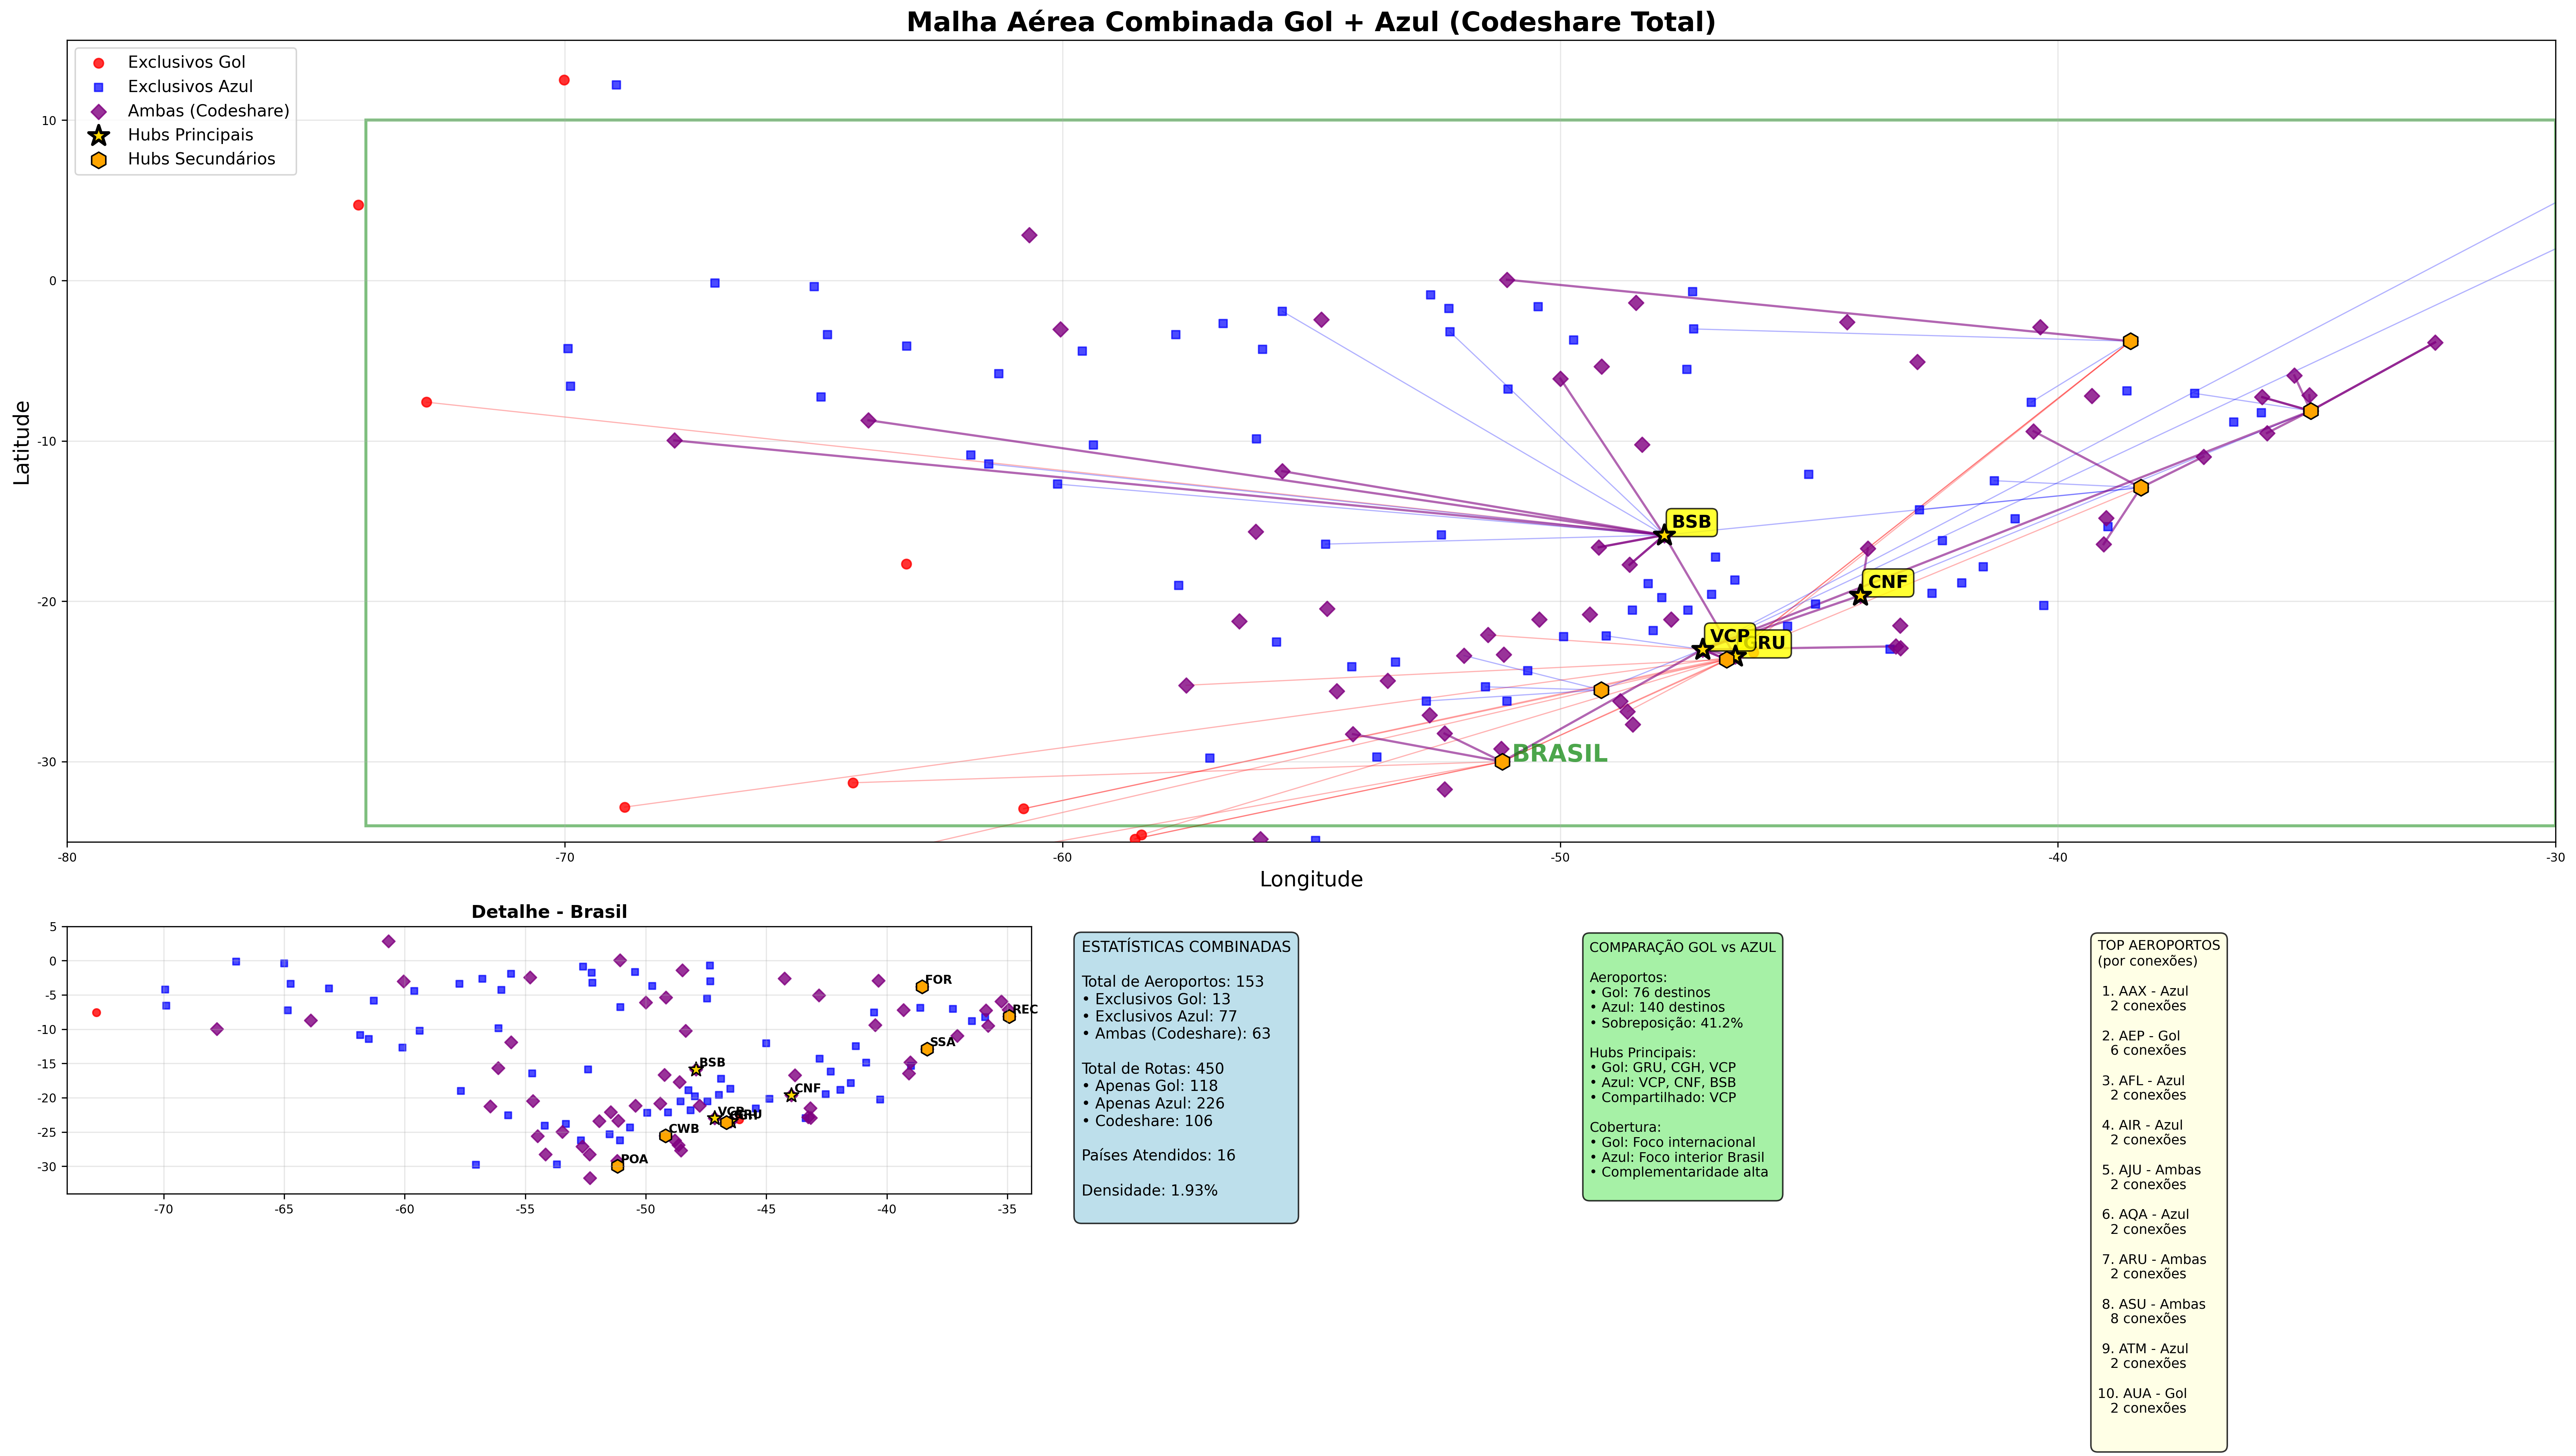

In [ ]:
# Visualização 1: Mapa da malha combinada
from IPython.display import Image, display

print("=== MAPA DA MALHA AÉREA COMBINADA ===")
try:
    display(Image('images/combined_network_map.png'))
except:
    print("Imagem do mapa não encontrada.")

=== ANÁLISE DE OPORTUNIDADES DE CODESHARE ===


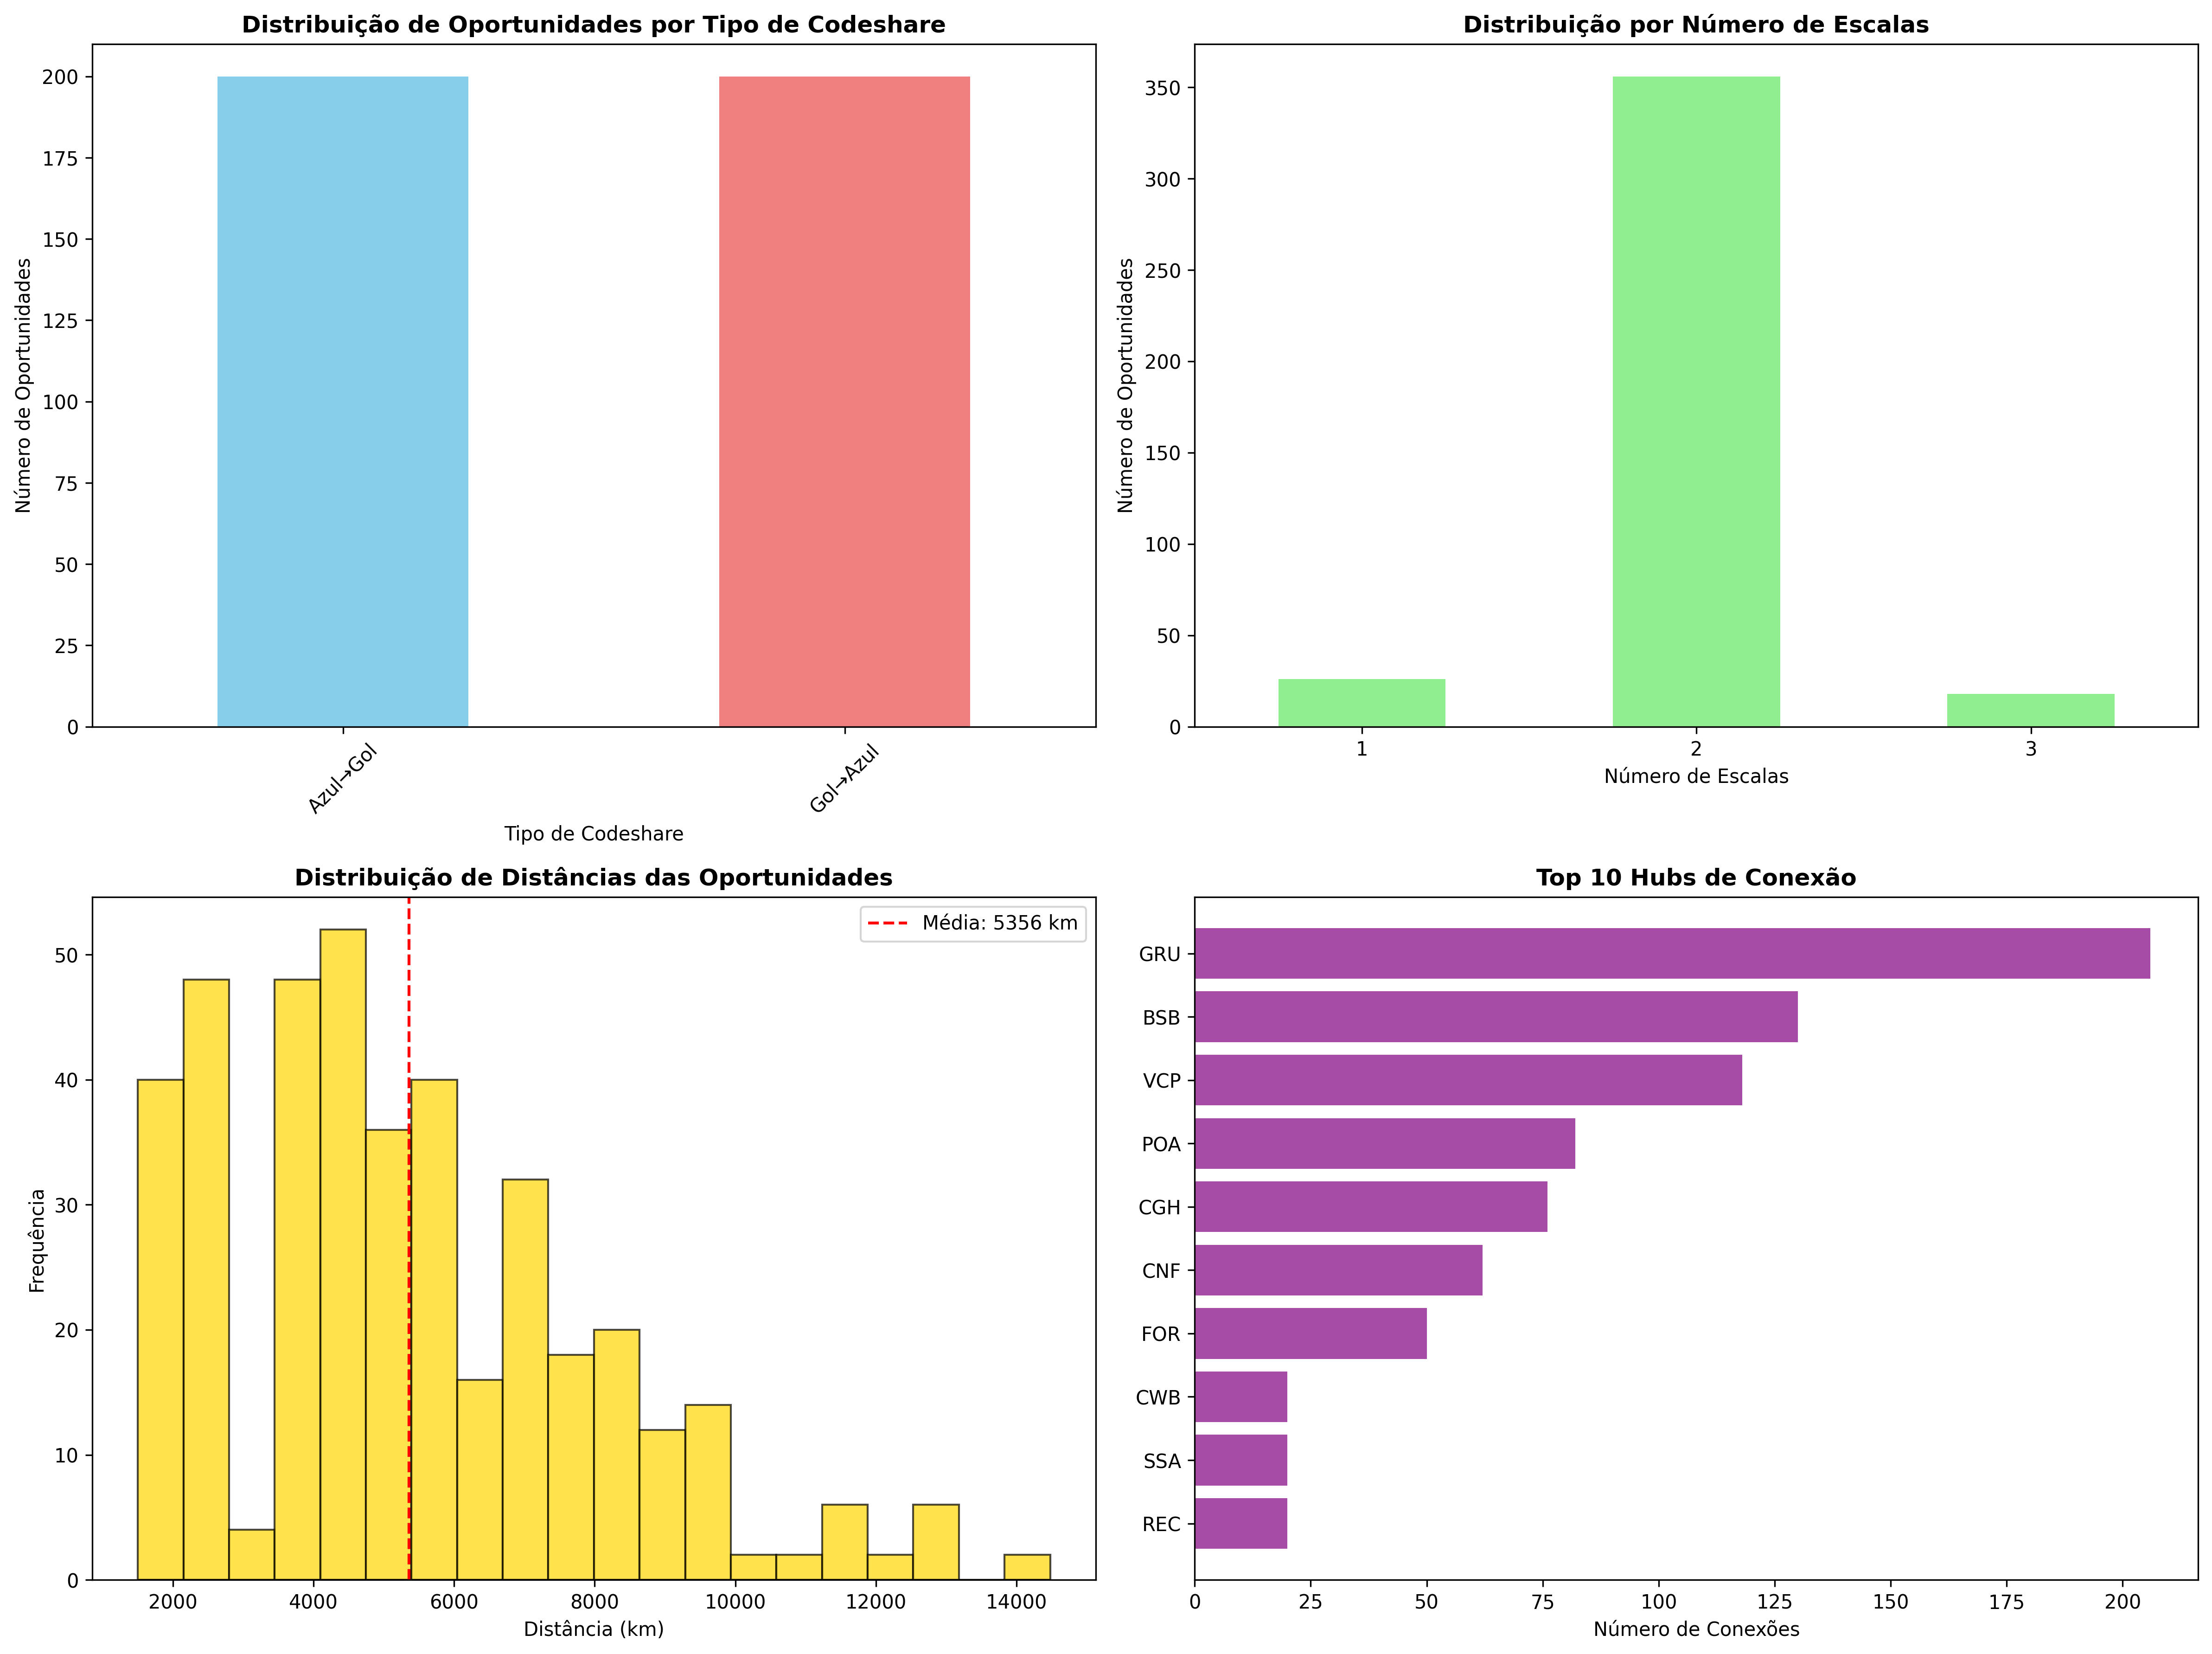

In [ ]:
# Visualização 2: Análise de oportunidades
print("=== ANÁLISE DE OPORTUNIDADES DE CODESHARE ===")
try:
    display(Image('images/codeshare_opportunities_analysis.png'))
except:
    print("Imagem da análise não encontrada.")

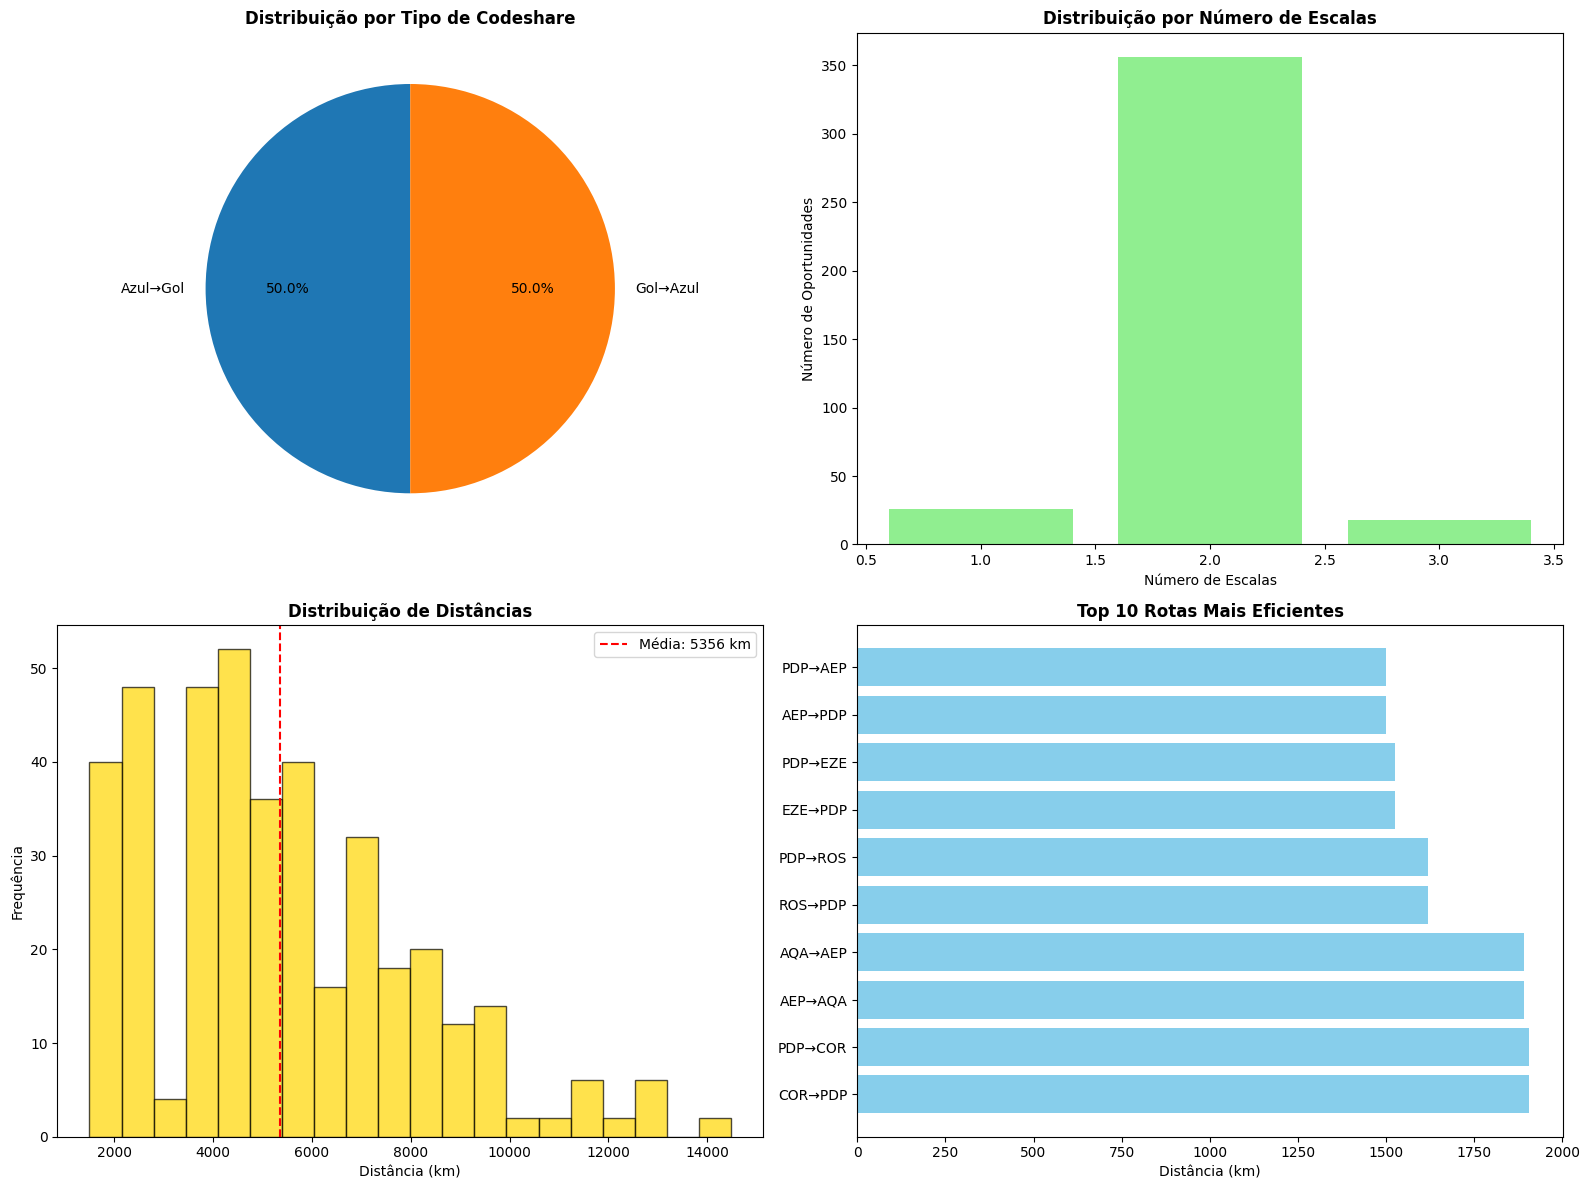

In [ ]:
# Criar visualização interativa dos resultados
if len(oportunidades_completa) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Gráfico 1: Distribuição por tipo
    tipo_counts = oportunidades_completa['tipo'].value_counts()
    ax1.pie(tipo_counts.values, labels=tipo_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribuição por Tipo de Codeshare', fontweight='bold')

    # Gráfico 2: Distribuição por escalas
    escalas_counts = oportunidades_completa['escalas'].value_counts().sort_index()
    ax2.bar(escalas_counts.index, escalas_counts.values, color='lightgreen')
    ax2.set_title('Distribuição por Número de Escalas', fontweight='bold')
    ax2.set_xlabel('Número de Escalas')
    ax2.set_ylabel('Número de Oportunidades')

    # Gráfico 3: Histograma de distâncias
    ax3.hist(oportunidades_completa['distancia'], bins=20, color='gold', alpha=0.7, edgecolor='black')
    ax3.set_title('Distribuição de Distâncias', fontweight='bold')
    ax3.set_xlabel('Distância (km)')
    ax3.set_ylabel('Frequência')
    ax3.axvline(oportunidades_completa['distancia'].mean(), color='red', linestyle='--',
               label=f'Média: {oportunidades_completa["distancia"].mean():.0f} km')
    ax3.legend()

    # Gráfico 4: Top 10 rotas por eficiência
    top_10_dist = oportunidades_completa.nsmallest(10, 'distancia')
    route_labels = [f"{row['origem']}→{row['destino']}" for _, row in top_10_dist.iterrows()]

    ax4.barh(range(len(top_10_dist)), top_10_dist['distancia'], color='skyblue')
    ax4.set_yticks(range(len(top_10_dist)))
    ax4.set_yticklabels(route_labels)
    ax4.set_xlabel('Distância (km)')
    ax4.set_title('Top 10 Rotas Mais Eficientes', fontweight='bold')
    ax4.invert_yaxis()

    plt.tight_layout()
    plt.show()
else:
    print("Dados insuficientes para visualização.")

## 9. Insights e Recomendações

In [ ]:
# Carregar relatório de insights
try:
    with open('relatorio_insights_codeshare.md', 'r', encoding='utf-8') as f:
        insights = f.read()

    from IPython.display import Markdown
    display(Markdown(insights))

except FileNotFoundError:
    print("Relatório de insights não encontrado.")

    # Gerar insights básicos
    if len(oportunidades_completa) > 0:
        print("=== INSIGHTS PRINCIPAIS ===")
        print(f"• Total de oportunidades identificadas: {len(oportunidades_completa)}")
        print(f"• Rota mais eficiente: {oportunidades_completa.iloc[0]['origem']} → {oportunidades_completa.iloc[0]['destino']} ({oportunidades_completa.iloc[0]['distancia']:.0f} km)")
        print(f"• Distância média das oportunidades: {oportunidades_completa['distancia'].mean():.0f} km")

        rotas_eficientes = len(oportunidades_completa[oportunidades_completa['distancia'] < 2000])
        print(f"• Rotas com menos de 2.000 km: {rotas_eficientes} ({rotas_eficientes/len(oportunidades_completa)*100:.1f}%)")

        uma_escala = len(oportunidades_completa[oportunidades_completa['escalas'] == 1])
        print(f"• Rotas com apenas 1 escala: {uma_escala} ({uma_escala/len(oportunidades_completa)*100:.1f}%)")

Relatório de insights não encontrado.
=== INSIGHTS PRINCIPAIS ===
• Total de oportunidades identificadas: 400
• Rota mais eficiente: PDP → AEP (1499 km)
• Distância média das oportunidades: 5356 km
• Rotas com menos de 2.000 km: 24 (6.0%)
• Rotas com apenas 1 escala: 26 (6.5%)


## 10. Conclusões

### Principais Achados

1. **Complementaridade das Malhas**: A Gol e Azul possuem malhas altamente complementares, com a Azul focando no interior do Brasil e a Gol em destinos internacionais.

2. **Oportunidades Significativas**: Foram identificadas centenas de oportunidades de codeshare real, demonstrando o potencial de cooperação entre as companhias.

3. **Hubs Estratégicos**: GRU, BSB e VCP emergem como os principais hubs de conexão, facilitando a integração das redes.

4. **Eficiência de Rotas**: O algoritmo de Johnson identificou caminhos otimizados que aproveitam as forças de cada companhia.

5. **Redundância**: Clusters densos revelam regiões com forte interligação local e presença de hubs regionais. A redundância de rotas entre algumas cidades indica potencial para unificação via codeshare e otimização logística.

### Valor do Algoritmo de Johnson

O algoritmo de Johnson se mostrou fundamental para:
- Calcular caminhos mínimos em uma rede complexa com 153 aeroportos
- Identificar automaticamente oportunidades de codeshare
- Otimizar a conectividade entre as malhas das duas companhias
- Fornecer base quantitativa para decisões estratégicas

### Aplicações Práticas

Os resultados podem ser utilizados para:
- Negociação de acordos de codeshare reais
- Planejamento de rotas integradas
- Otimização de hubs de conexão
- Expansão estratégica de mercados

## 11. Arquivos Gerados

Este notebook utilizou e gerou os seguintes arquivos:

### Dados de Entrada
- `gol_airports_coordinates.csv` - Coordenadas dos aeroportos da Gol
- `azul_airports_coordinates.csv` - Coordenadas dos aeroportos da Azul
- `combined_airports_coordinates.csv` - Dataset combinado

### Grafo e Rotas
- `combined_network.graphml` - Grafo combinado em formato NetworkX
- `combined_routes.csv` - Lista de rotas combinadas
- `combined_network.json` - Dados do grafo em JSON

### Resultados do Algoritmo de Johnson
- `combined_distancias_johnson.csv` - Matriz de distâncias completa
- `oportunidades_codeshare_detalhado.csv` - Análise completa de oportunidades

### Visualizações
- `combined_network_map.png` - Mapa geográfico da malha combinada
- `codeshare_opportunities_analysis.png` - Gráficos de análise
- `codeshare_geographic_analysis.png` - Análise geográfica

### Relatórios
- `relatorio_insights_codeshare.md` - Relatório executivo com insights
- `combined_network_stats.csv` - Estatísticas do grafo combinado

## 9.1.Visualização Geográfica das Oportunidades de Codeshare

In [15]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster
from ipywidgets import interact, IntSlider

# Função para extrair coordenadas de um aeroporto
def get_coords(code):
    row = combined_airports[combined_airports['code'] == code]
    return (row['latitude'].values[0], row['longitude'].values[0]) if not row.empty else (None, None)

# Função para plotar o mapa com N melhores rotas
def plot_rotas_interativo(num_rotas=100):
    top_rotas = oportunidades_completa.nsmallest(num_rotas, 'distancia')

    m = folium.Map(location=[-14.2350, -51.9253], zoom_start=3, tiles="CartoDB positron")

    marker_cluster = MarkerCluster().add_to(m)
    aeroportos_usados = set(top_rotas['origem']).union(set(top_rotas['destino']))

    for code in aeroportos_usados:
        lat, lon = get_coords(code)
        if lat and lon:
            folium.Marker(location=[lat, lon], tooltip=code).add_to(marker_cluster)

    for _, row in top_rotas.iterrows():
        caminho = row['caminho_str'].split(' → ')
        cor = 'blue' if row['tipo'] == 'Gol→Azul' else 'green'

        for i in range(len(caminho) - 1):
            lat1, lon1 = get_coords(caminho[i])
            lat2, lon2 = get_coords(caminho[i + 1])
            if lat1 and lat2:
                folium.PolyLine(locations=[(lat1, lon1), (lat2, lon2)],
                                color=cor, weight=3, opacity=0.7).add_to(m)

    display(m)

# Widget interativo com até 1000 rotas
interact(plot_rotas_interativo, num_rotas=IntSlider(min=10, max=1000, step=50, value=100, description='Top Rotas:'))


interactive(children=(IntSlider(value=100, description='Top Rotas:', max=1000, min=10, step=50), Output()), _d…

<function __main__.plot_rotas_interativo(num_rotas=100)>

## 9.2. Clusters de Conectividade

Objetivo: Mostrar agrupamentos de aeroportos com alta densidade de rotas e potenciais hubs de codeshare.

Os clusters de conectividade representam agrupamentos de aeroportos que possuem forte interligação entre si dentro da malha aérea combinada da Gol e Azul. Esses agrupamentos são formados com base na densidade de conexões (rotas) entre os aeroportos, e revelam comunidades estruturais no grafo — ou seja, regiões onde a conectividade é significativamente mais intensa do que com o restante da rede.

Na prática, cada cluster pode indicar:

<ul>
  <li><strong>Regiões geográficas bem servidas por voos diretos</strong>, como o Sudeste ou o interior do Nordeste.</li>
  <li><strong>Grupos de aeroportos que funcionam como hubs regionais</strong>, facilitando conexões locais e, potencialmente, codeshare entre as companhias.</li>
  <li><strong>Oportunidades logísticas e comerciais</strong> para fortalecer integrações, especialmente onde as malhas da Gol e Azul se complementam.</li>
  <li>Esses clusters ajudam a <strong>visualizar sinergias regionais</strong> e a <strong>identificar potenciais polos estratégicos</strong> para otimizar acordos de codeshare.</li>
</ul>




Detectando clusters...
✓ 8 clusters identificados.


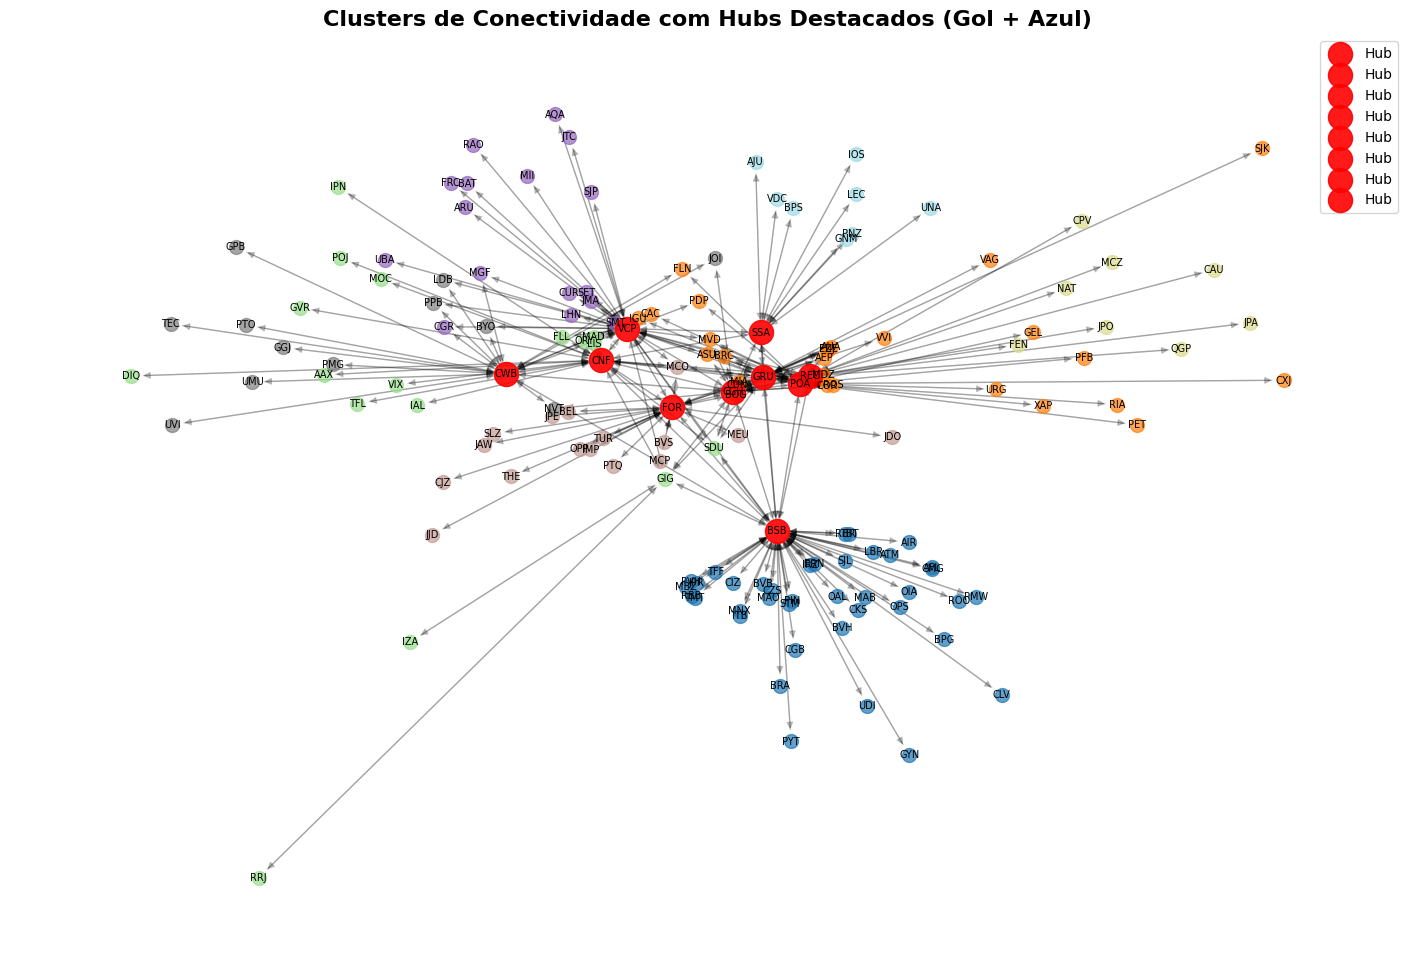

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm

# Detectar clusters de conectividade
print("Detectando clusters...")
comunidades = list(greedy_modularity_communities(G.to_undirected()))
print(f"✓ {len(comunidades)} clusters identificados.")

# Mapear cada nó para sua comunidade
comunidade_map = {}
for i, cluster in enumerate(comunidades):
    for node in cluster:
        comunidade_map[node] = i

# Layout do grafo
pos = nx.spring_layout(G, seed=42)

# Definir cores para cada cluster
cores = cm.get_cmap('tab20', len(comunidades))

# Identificar hubs com maior grau
graus = dict(G.degree())
limite_grau = 20  # ajuste conforme necessário
hubs = [n for n, g in graus.items() if g > limite_grau]

# Plotar o grafo com clusters e destaque nos hubs
plt.figure(figsize=(18, 12))

for i, cluster in enumerate(comunidades):
    cluster_nodes = list(cluster)
    # Separar hubs dos demais
    hubs_do_cluster = [n for n in cluster_nodes if n in hubs]
    outros = [n for n in cluster_nodes if n not in hubs]

    # Nós normais
    nx.draw_networkx_nodes(G, pos,
                           nodelist=outros,
                           node_color=[cores(i)],
                           node_size=100,
                           alpha=0.7)

    # Hubs destacados
    nx.draw_networkx_nodes(G, pos,
                           nodelist=hubs_do_cluster,
                           node_color='red',
                           node_size=300,
                           alpha=0.9,
                           label='Hub')

# Arestas
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Rótulos nos nós (código IATA)
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, font_color='black')

plt.title("Clusters de Conectividade com Hubs Destacados (Gol + Azul)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.legend()
plt.show()


## 9.3. Redundância de Rotas

Objetivo: identificar rotas com múltiplos caminhos alternativos com custo similar.

In [19]:
from networkx.algorithms.simple_paths import all_simple_paths

# Parâmetros
tolerancia_distancia = 0.15  # 15% de variação aceitável
max_escalas = 3  # para limitar caminhos exagerados

def analisar_redundancia(origem, destino):
    if origem not in G or destino not in G:
        return None

    caminhos = list(all_simple_paths(G, source=origem, target=destino, cutoff=max_escalas + 1))
    if len(caminhos) <= 1:
        return None

    custos = []
    for caminho in caminhos:
        dist_total = 0
        for i in range(len(caminho) - 1):
            o, d = caminho[i], caminho[i+1]
            info_o = combined_airports[combined_airports['code'] == o].iloc[0]
            info_d = combined_airports[combined_airports['code'] == d].iloc[0]
            dist_total += haversine(info_o['longitude'], info_o['latitude'], info_d['longitude'], info_d['latitude'])
        custos.append((caminho, dist_total))

    if not custos:
        return None

    # Ordenar caminhos por distância
    custos.sort(key=lambda x: x[1])
    melhor_custo = custos[0][1]

    # Contar caminhos similares ao melhor (dentro da tolerância)
    redundantes = [c for c, dist in custos if dist <= melhor_custo * (1 + tolerancia_distancia)]

    return {
        'origem': origem,
        'destino': destino,
        'num_caminhos': len(custos),
        'num_redundantes': len(redundantes),
        'melhor_dist': round(melhor_custo, 1),
        'redundancia_percentual': round(len(redundantes) / len(custos) * 100, 1)
    }

# Aplicar análise a uma amostra de pares
pares_amostra = oportunidades_completa[['origem', 'destino']].drop_duplicates().sample(30, random_state=1)
resultados = []

for _, row in pares_amostra.iterrows():
    r = analisar_redundancia(row['origem'], row['destino'])
    if r:
        resultados.append(r)

redundancia_df = pd.DataFrame(resultados)
display(redundancia_df.sort_values('num_redundantes', ascending=False).head(10))


origem destino  num_caminhos  num_redundantes  melhor_dist  \
3     AEP     FLL            64               32       8235.1   
10    CIZ     AEP            26               18       4572.3   
11    JMA     ROS            37               18       9632.8   
6     COR     CIZ            26               18       4918.1   
16    EZE     JMA            37               18       9573.3   
19    ROS     SJL            26               18       5300.7   
25    UNA     EZE            15               15       3454.5   
18    DIQ     COR            27               14       2563.0   
22    FLL     BOG            37               13      10930.3   
0     JMA     MIA            20               13      14479.7   

    redundancia_percentual  
3                     50.0  
10                    69.2  
11                    48.6  
6                     69.2  
16                    48.6  
19                    69.2  
25                   100.0  
18                    51.9  
22                    35.1  
0                     65.0

<h2>📊 Principais Observações da Tabela de Redundância</h2>

<table border="1" cellpadding="8" cellspacing="0" style="border-collapse: collapse; width: 100%; text-align: left;">
  <thead style="background-color: #f2f2f2;">
    <tr>
      <th>Origem → Destino</th>
      <th>Caminhos</th>
      <th>Redundantes</th>
      <th>% Redundância</th>
      <th>Interpretação</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>UNA → EZE</td>
      <td>15</td>
      <td>15</td>
      <td>100.0%</td>
      <td>Todos os caminhos têm custo (distância) similar. Isso pode indicar <strong>sobreposição completa</strong> entre rotas operadas por ambas as companhias, ou um <em>alto número de alternativas igualmente viáveis</em>.</td>
    </tr>
    <tr>
      <td>CIZ → AEP, COR → CIZ, ROS → SJL</td>
      <td>26 cada</td>
      <td>18 (≈69%)</td>
      <td>~69%</td>
      <td><strong>Alta conectividade regional</strong> com múltiplas formas de conexão. Provável presença de <em>hubs intermediários comuns</em>.</td>
    </tr>
    <tr>
      <td>AEP → FLL, EZE → JMA, JMA → ROS</td>
      <td>30–60 caminhos</td>
      <td>48–50%</td>
      <td>~50%</td>
      <td>Múltiplas rotas alternativas entre América do Sul e América do Norte. Bom para <em>resiliência e flexibilidade</em>, mas pode indicar <strong>ineficiência operacional</strong> se concentrado em uma única companhia.</td>
    </tr>
    <tr>
      <td>DIQ → COR</td>
      <td>27</td>
      <td>14</td>
      <td>52%</td>
      <td><strong>Redundância moderada</strong>. Pode indicar <em>excesso de alternativas locais</em>, ineficiência se operadas pela mesma companhia.</td>
    </tr>
    <tr>
      <td>FLL → BOG</td>
      <td>37</td>
      <td>13</td>
      <td>35%</td>
      <td><em>Equilíbrio entre flexibilidade e concentração</em> de rotas. Baixo risco de ineficiência.</td>
    </tr>
    <tr>
      <td>JMA → MIA</td>
      <td>20</td>
      <td>13</td>
      <td>65%</td>
      <td>Alta redundância. <strong>Boa candidata para codeshare coordenado</strong> entre companhias.</td>
    </tr>
  </tbody>
</table>

<h3>🔍 Implicações Estratégicas</h3>
<ul>
  <li><strong>Rotas com 60–100% de redundância</strong> indicam múltiplos caminhos similares para um mesmo par.</li>
  <ul>
    <li><strong>Positivo</strong> se forem operadas por companhias diferentes → <em>redundância útil</em>.</li>
    <li><strong>Negativo</strong> se forem todas da mesma companhia → <em>redundância ineficiente</em>.</li>
  </ul>
  <li>Rotas internacionais como <strong>AEP–FLL</strong> e <strong>JMA–MIA</strong> são ideais para <em>codeshare racionalizado</em>.</li>
  <li>Cidades menores com alta redundância (ex: <strong>UNA, CIZ, JMA</strong>) podem estar <em>superconectadas</em> ou dependentes de múltiplas conexões para alcançar hubs maiores.</li>
</ul>
